In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# import rpy2
%load_ext rpy2.ipython

C:\Program Files\Python310\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [2]:
%%R
library(ggplot2)
library(scales)
library(patchwork)

library(gt)
library(xtable)
library(dplyr)
library(tidyr)

R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




# Load data

In [3]:
# name_dict = {
#     "Kernel-GOMEA---Asymmetric": "Kernel GOMEA - Asymmetric",
#     "Kernel-GOMEA---Symmetric": "Kernel GOMEA - Symmetric",
# }
name_dict = {
    "DSMGA2": "DSMGA-II",
    "Kernel-GOMEA---Asymmetric": "LK-GOMEA (Asym)",
    "Kernel-GOMEA---Symmetric": "LK-GOMEA (Sym)",
}

In [19]:
res_maxcut = pd.concat([
    pd.read_csv("./paper_singleobjective_e963b42_maxcut.csv.gz"), # Standard run data
    pd.read_csv("2021-12-24-paper_singleobjective_extra_1fc247f_maxcut.csv.gz"), # data for l=200 for maxcut
])
res_maxcut["kind"] = "MaxCut"

res_wo_maxcut = pd.concat([
    pd.read_csv("./2022-01-25-paper_singleobjective_19451c0_wo_maxcut.csv.gz"), # Standard run data
])
res_wo_maxcut["kind"] = "Worst-of-MaxCuts"

res = pd.concat([
    res_maxcut,
    res_wo_maxcut
])

res["approach"] = res["approach"].replace(name_dict)
res

,#evaluations,time(ms),fitness,isKey,populationSize,solution,approach,run,l,kind
0,1,0,28.0,0,2,101011,LK-GOMEA (Sym),12,6,MaxCut
1,5,0,29.0,1,4,011100,LK-GOMEA (Sym),12,6,MaxCut
2,1,0,7464.0,0,2,0010001000100000101101000100111000101110001100...,LK-GOMEA (Asym),19,100,MaxCut
3,3,4,7508.0,0,4,0110000100101111101000111111000000001111011101...,LK-GOMEA (Asym),19,100,MaxCut
4,5,4,7510.0,0,4,0000100101100010110111111101011011111101000000...,LK-GOMEA (Asym),19,100,MaxCut
...,...,...,...,...,...,...,...,...,...,...
14346,19284,134,2015.0,0,16,1110100001111010000101010100001010111010111101...,DSMGA-II,11,50,Worst-of-MaxCuts
14347,21905,150,2019.0,0,32,0110101100101110010101010000000010111010111101...,DSMGA-II,11,50,Worst-of-MaxCuts
14348,30937,185,2020.0,0,32,0110100101101010010101010100000010111010111101...,DSMGA-II,11,50,Worst-of-MaxCuts
14349,37598,216,2021.0,0,32,0110100101101010010101010100001010111010111101...,DSMGA-II,11,50,Worst-of-MaxCuts


In [20]:
setting_columns = ["approach", "l", "kind"]
run_columns = setting_columns + ["run"]

# Scalability: #evaluations
How many evaluations does it take to get to the optimum?

In [21]:
# Derive the hitting point in #evaluations
def process_run(run_df):
    sorted_run_df = run_df.sort_values("#evaluations")
    potential_keypoint = sorted_run_df.iloc[-1]
    if potential_keypoint["isKey"]:
        return potential_keypoint["#evaluations"]
    else:
        return np.nan

hitting_evaluations = res.groupby(run_columns).apply(process_run).rename("hitting #evaluations").reset_index()

In [22]:
# Quick check if everything is finite (not the case if not all runs hit the optimum!)
def all_finite(df):
    return np.isfinite(df["hitting #evaluations"]).all()

hef = hitting_evaluations.groupby(setting_columns).apply(all_finite).rename("all runs finite").reset_index()
hitting_evaluations_af = pd.merge(hitting_evaluations, hef)
hitting_evaluations_af = hitting_evaluations_af[hitting_evaluations_af["all runs finite"]].copy()

In [23]:
# Compute statistics - replacing nan with inf
hitting_evaluations_q = hitting_evaluations.fillna(np.inf).groupby(setting_columns)["hitting #evaluations"].quantile([0.05, 0.5, 0.95]).unstack().fillna(np.inf).reset_index()
# hitting_evaluations_q.loc[~np.isfinite(hitting_evaluations_q[0.9]) & np.isfinite(hitting_evaluations_q[0.5]), 0.9] = max_evaluations
# Remove points where median is inf.
hitting_evaluations_q = hitting_evaluations_q[np.isfinite(hitting_evaluations_q[0.5])]
hitting_evaluations_q

,approach,l,kind,0.05,0.5,0.95
0,DSMGA-II,6,MaxCut,4.00,16.0,44.70
1,DSMGA-II,6,Worst-of-MaxCuts,4.00,12.0,40.30
2,DSMGA-II,12,MaxCut,6.45,204.0,361.75
3,DSMGA-II,12,Worst-of-MaxCuts,75.50,529.5,1335.90
4,DSMGA-II,25,MaxCut,725.10,3552.5,17106.65
5,DSMGA-II,25,Worst-of-MaxCuts,1008.15,3785.5,25230.30
6,DSMGA-II,50,MaxCut,14241.00,35211.0,165371.70
7,DSMGA-II,50,Worst-of-MaxCuts,16466.60,55128.0,126525.40
8,DSMGA-II,100,MaxCut,324693.95,895764.5,7514947.95
9,DSMGA-II,100,Worst-of-MaxCuts,7502261.05,52927575.0,inf


R[write to console]: Saving 6.94 x 4.17 in image

R[write to console]: Saving 6.94 x 4.17 in image



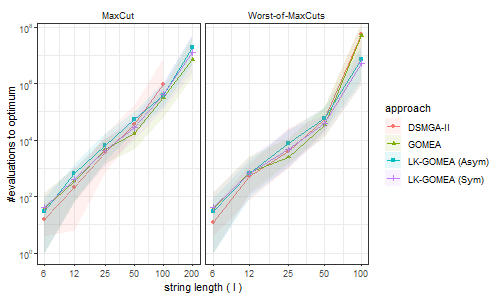

In [24]:
%%R -i hitting_evaluations_q -w 500 -h 300
plt <- ggplot(hitting_evaluations_q, aes(x=l, y=`0.5`, ymin=`0.05`, ymax=`0.95`, shape=`approach`, color=`approach`, fill=`approach`)) + 
    geom_line() +
    geom_point() +
    geom_ribbon(alpha=0.1, color=NA) +
    # Nice axis labels courtesy of https://stackoverflow.com/a/18526649/4224646
    # Now only used for the y-axis
    # scale_x_log10(
    #     breaks=trans_breaks("log10", function(x) 10^x),
    #     labels=trans_format("log10", math_format(10^.x))) +
    # scale_y_log10(
    #     breaks=trans_breaks("log10", function(x) 10^x),
    #     labels=trans_format("log10", math_format(10^.x))
    # ) +
    scale_x_log10(
        breaks=unique(hitting_evaluations_q$l)
        # labels=trans_format("log10", math_format(10^.x))
    ) +
    scale_y_log10(
        breaks=trans_breaks("log10", function(x) 10^x),
    labels=trans_format("log10", math_format(10^.x))
    ) +
    facet_grid(. ~ `kind`, scales = "free_x") +
    labs(x=expression("string length (" ~ l ~ ")"), y="#evaluations to optimum") +
    theme_bw() +
    theme(strip.background = element_rect(fill = NA, color=NA))

ggsave("./2022-01-25-paper_maxcut_wo_maxcut_scalability_evals.png")
ggsave("./2022-01-25-paper_maxcut_wo_maxcut_scalability_evals.pdf", device=cairo_pdf)
plt

# Scalability: Time
How much time does it take to get to the optimum?

In [25]:
# Derive the hitting point in #evaluations
def process_run(run_df):
    sorted_run_df = run_df.sort_values("time(ms)")
    potential_keypoint = sorted_run_df.iloc[-1]
    if potential_keypoint["isKey"]:
        return potential_keypoint["time(ms)"] + 1
    else:
        return np.nan

hitting_time = res.groupby(run_columns).apply(process_run).rename("hitting time (ms)").reset_index()

In [26]:
# Quick check if everything is finite (not the case if not all runs hit the optimum!)
def all_finite(df):
    return np.isfinite(df["hitting time (ms)"]).all()

hef = hitting_time.groupby(setting_columns).apply(all_finite).rename("all runs finite").reset_index()
hitting_time_af = pd.merge(hitting_time, hef)
hitting_time_af = hitting_time_af[hitting_time_af["all runs finite"]].copy()

In [27]:
# Compute statistics - replacing nan with inf
hitting_time_q = hitting_time.fillna(np.inf).groupby(setting_columns)["hitting time (ms)"].quantile([0.05, 0.5, 0.95]).unstack().fillna(np.inf).reset_index()
# hitting_time_q.loc[~np.isfinite(hitting_time_q[0.9]) & np.isfinite(hitting_time_q[0.5]), 0.9] = max_evaluations
# Remove points where median is inf.
hitting_time_q = hitting_time_q[np.isfinite(hitting_time_q[0.5])]
hitting_time_q

,approach,l,kind,0.05,0.5,0.95
0,DSMGA-II,6,MaxCut,1.00,1.0,2.00
1,DSMGA-II,6,Worst-of-MaxCuts,1.00,1.0,2.00
2,DSMGA-II,12,MaxCut,1.00,2.0,2.00
3,DSMGA-II,12,Worst-of-MaxCuts,1.00,2.0,2.55
4,DSMGA-II,25,MaxCut,3.00,11.5,36.65
5,DSMGA-II,25,Worst-of-MaxCuts,3.45,10.5,40.30
6,DSMGA-II,50,MaxCut,96.30,220.0,880.35
7,DSMGA-II,50,Worst-of-MaxCuts,108.30,306.0,626.65
8,DSMGA-II,100,MaxCut,6247.35,17009.5,113048.85
9,DSMGA-II,100,Worst-of-MaxCuts,115926.85,870892.5,inf


R[write to console]: Saving 6.94 x 4.17 in image

R[write to console]: Saving 6.94 x 4.17 in image



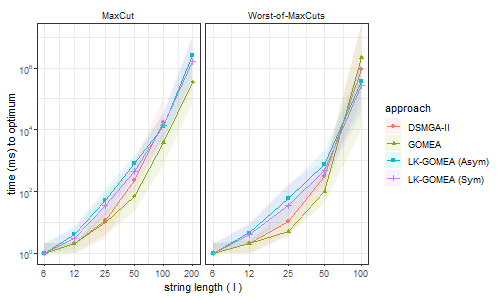

In [28]:
%%R -i hitting_time_q -w 500 -h 300
plt <- ggplot(hitting_time_q, aes(x=l, y=`0.5`, ymin=`0.05`, ymax=`0.95`, shape=`approach`, color=`approach`, fill=`approach`)) + 
    geom_line() +
    geom_point() +
    geom_ribbon(alpha=0.1, color=NA) +
    # Nice axis labels courtesy of https://stackoverflow.com/a/18526649/4224646
    # scale_x_log10(
    #     breaks=trans_breaks("log10", function(x) 10^x),
    #     labels=trans_format("log10", math_format(10^.x))) +
    scale_y_log10(
        breaks=trans_breaks("log10", function(x) 10^x),
        labels=trans_format("log10", math_format(10^.x))
    ) +
    scale_x_log10(
        breaks=unique(hitting_time_q$l)
    # labels=trans_format("log10", math_format(10^.x))
    ) +
    facet_grid(. ~ `kind`, scales = "free_x") +
    labs(x=expression("string length (" ~ l ~ ")"), y="time (ms) to optimum") +
    theme_bw() +
    theme(strip.background = element_rect(fill = NA, color=NA))# +
    #guides(color=guide_legend(nrow=2,byrow=TRUE), fill=guide_legend(nrow=2, byrow=TRUE), shape=guide_legend(nrow=2, byrow=TRUE),) +
    #theme(legend.position="bottom")

ggsave("./2022-01-25-paper_maxcut_wo_maxcut_scalability_time.png")
ggsave("./2022-01-25-paper_maxcut_wo_maxcut_scalability_time.pdf", device=cairo_pdf)
plt

# Scalability Merged

R[write to console]: Saving 6.94 x 2.78 in image

R[write to console]: Saving 6.94 x 2.78 in image



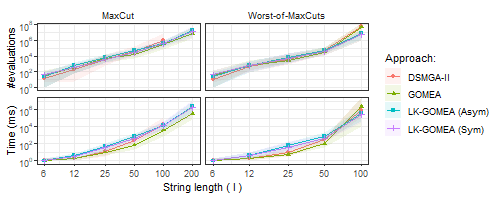

In [17]:
%%R -i hitting_evaluations_q -i hitting_time_q -w 500 -h 200
plt_eval <- ggplot(hitting_evaluations_q, aes(x=l, y=`0.5`, ymin=`0.05`, ymax=`0.95`, shape=`approach`, color=`approach`, fill=`approach`)) +
    geom_line() +
    geom_point() +
    geom_ribbon(alpha=0.1, color=NA) +
    # Nice axis labels courtesy of https://stackoverflow.com/a/18526649/4224646
    # scale_x_log10(
    #     breaks=trans_breaks("log10", function(x) 10^x),
    # labels=trans_format("log10", math_format(10^.x))) +
    scale_y_log10(
        breaks=trans_breaks("log10", function(x) 10^x),
    labels=trans_format("log10", math_format(10^.x))
    ) +
    scale_x_log10(
        breaks=unique(hitting_evaluations_q$l)
    # labels=trans_format("log10", math_format(10^.x))
    ) +
    facet_grid(. ~ `kind`, scales = "free_x") +
    labs(x=expression("String length (" ~ l ~ ")"), y="#evaluations", shape="Approach:", color="Approach:", fill="Approach:") +
    theme_bw() +
    theme(strip.background = element_rect(fill = NA, color=NA)) +
    theme(strip.background = element_rect(fill = NA, color=NA)) + theme(
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        axis.ticks.x = element_blank()
    ) +
    theme(plot.margin = margin(b = 2, unit = "pt"))


plt_time <- ggplot(hitting_time_q, aes(x=l, y=`0.5`, ymin=`0.05`, ymax=`0.95`, shape=`approach`, color=`approach`, fill=`approach`)) +
    geom_line() +
    geom_point() +
    geom_ribbon(alpha=0.1, color=NA) +
    # Nice axis labels courtesy of https://stackoverflow.com/a/18526649/4224646
    # scale_x_log10(
    #     breaks=trans_breaks("log10", function(x) 10^x),
    # labels=trans_format("log10", math_format(10^.x))) +
    scale_y_log10(
        breaks=trans_breaks("log10", function(x) 10^x),
    labels=trans_format("log10", math_format(10^.x))
    ) +
    scale_x_log10(
        breaks=unique(hitting_time_q$l)
    # labels=trans_format("log10", math_format(10^.x))
    ) +
    facet_grid(. ~ `kind`, scales = "free_x") +
    labs(x=expression("String length (" ~ l ~ ")"), y="Time (ms)", shape="Approach:", color="Approach:", fill="Approach:") +
    theme_bw() +
    theme(strip.text = element_blank()) + theme(plot.margin = margin(t = 2, unit = "pt"))
    #guides(color=guide_legend(nrow=2,byrow=TRUE), fill=guide_legend(nrow=2, byrow=TRUE), shape=guide_legend(nrow=2, byrow=TRUE),) +


plt <- ((plt_eval + theme(legend.position="bottom")) / (plt_time + theme(legend.position="bottom"))) +
    plot_layout(guides = 'collect') & theme(legend.position="right")
# ggsave("./2021-12-23-paper_maxcut_scalability_evalandtime.png")
# ggsave("./2021-12-23-paper_maxcut_scalability_evalandtime.pdf", device=cairo_pdf)
ggsave("./2022-01-25-paper_maxcut_wo_maxcut_scalability_evalandtime.png")
ggsave("./2022-01-25-paper_maxcut_wo_maxcut_scalability_evalandtime.pdf", device=cairo_pdf)
plt

R[write to console]: Saving 6.94 x 4.17 in image

R[write to console]: Saving 6.94 x 4.17 in image



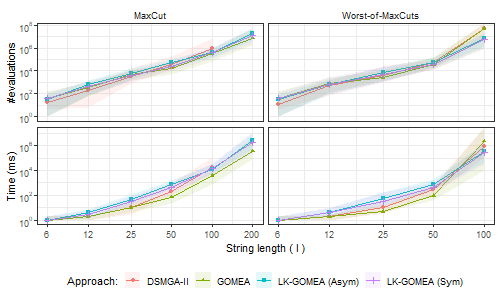

In [18]:
%%R -i hitting_evaluations_q -i hitting_time_q -w 500 -h 300
plt_eval <- ggplot(hitting_evaluations_q, aes(x=l, y=`0.5`, ymin=`0.05`, ymax=`0.95`, shape=`approach`, color=`approach`, fill=`approach`)) +
    geom_line() +
    geom_point() +
    geom_ribbon(alpha=0.1, color=NA) +
    # Nice axis labels courtesy of https://stackoverflow.com/a/18526649/4224646
    # scale_x_log10(
    #     breaks=trans_breaks("log10", function(x) 10^x),
    # labels=trans_format("log10", math_format(10^.x))) +
    scale_y_log10(
        breaks=trans_breaks("log10", function(x) 10^x),
    labels=trans_format("log10", math_format(10^.x))
    ) +
    scale_x_log10(
        breaks=unique(hitting_evaluations_q$l)
    # labels=trans_format("log10", math_format(10^.x))
    ) +
    facet_grid(. ~ `kind`, scales = "free_x") +
    labs(x=expression("String length (" ~ l ~ ")"), y="#evaluations", shape="Approach:", color="Approach:", fill="Approach:") +
    theme_bw() +
    theme(strip.background = element_rect(fill = NA, color=NA)) +
    theme(strip.background = element_rect(fill = NA, color=NA)) + theme(
        axis.text.x = element_blank(),
        axis.title.x = element_blank(),
        axis.ticks.x = element_blank()
    ) +
    theme(plot.margin = margin(b = 2, unit = "pt"))


plt_time <- ggplot(hitting_time_q, aes(x=l, y=`0.5`, ymin=`0.05`, ymax=`0.95`, shape=`approach`, color=`approach`, fill=`approach`)) +
    geom_line() +
    geom_point() +
    geom_ribbon(alpha=0.1, color=NA) +
    # Nice axis labels courtesy of https://stackoverflow.com/a/18526649/4224646
    # scale_x_log10(
    #     breaks=trans_breaks("log10", function(x) 10^x),
    # labels=trans_format("log10", math_format(10^.x))) +
    scale_y_log10(
        breaks=trans_breaks("log10", function(x) 10^x),
    labels=trans_format("log10", math_format(10^.x))
    ) +
    scale_x_log10(
        breaks=unique(hitting_time_q$l)
    # labels=trans_format("log10", math_format(10^.x))
    ) +
    facet_grid(. ~ `kind`, scales = "free_x") +
    labs(x=expression("String length (" ~ l ~ ")"), y="Time (ms)", shape="Approach:", color="Approach:", fill="Approach:") +
    theme_bw() +
    theme(strip.text = element_blank()) + theme(plot.margin = margin(t = 2, unit = "pt"))
    #guides(color=guide_legend(nrow=2,byrow=TRUE), fill=guide_legend(nrow=2, byrow=TRUE), shape=guide_legend(nrow=2, byrow=TRUE),) +


plt <- ((plt_eval + theme(legend.position="bottom")) / (plt_time + theme(legend.position="bottom"))) +
    plot_layout(guides = 'collect') & theme(legend.position="bottom")
# ggsave("./2021-12-23-paper_maxcut_scalability_evalandtime.png")
# ggsave("./2021-12-23-paper_maxcut_scalability_evalandtime.pdf", device=cairo_pdf)
ggsave("./2022-01-25-paper_maxcut_wo_maxcut_scalability_evalandtime_lb.png")
ggsave("./2022-01-25-paper_maxcut_wo_maxcut_scalability_evalandtime_lb.pdf", device=cairo_pdf)
plt

# Reliability
How often does the approach actually find the optimum?

In [30]:
def count_ratio_finite(df):
    return np.mean(np.isfinite(df))
ratio_success = hitting_evaluations.groupby(setting_columns)["hitting #evaluations"].apply(count_ratio_finite).rename("P(success)").reset_index()

ratio_success_style = ratio_success.pivot(["l", "kind"], "approach", "P(success)").style.background_gradient(cmap='gray', axis=1, vmin=0, vmax=1)
ratio_success_style

R[write to console]: Saving 6.94 x 4.17 in image

R[write to console]: Saving 6.94 x 4.17 in image



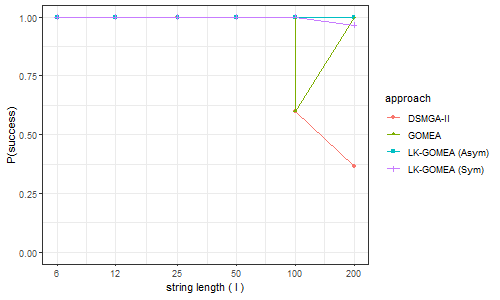

In [31]:
%%R -i ratio_success -w 500 -h 300
plt <- ggplot(ratio_success, aes(x=`l`, y=`P(success)`, color=`approach`, shape=`approach`)) +
    geom_point() +
    geom_line() +
    ylim(0, 1) +
    # scale_x_log10(
    #     breaks=trans_breaks("log10", function(x) 10^x),
    #     labels=trans_format("log10", math_format(10^.x))) +
    scale_x_log10(
        breaks=unique(ratio_success$l)
    # labels=trans_format("log10", math_format(10^.x))
    ) +
    labs(x=expression("string length (" ~ l ~ ")")) +
    theme_bw() +
    theme(strip.background = element_rect(fill = NA, color=NA))

ggsave("./2022-01-25-paper_wo_maxcut_reliability.png")
ggsave("./2022-01-25-paper_wo_maxcut_reliability.pdf", device = cairo_pdf)
plt

In [25]:
subset = ["approach", "l", 0.5]
hitting_medians = pd.merge(hitting_evaluations_q[subset], hitting_time_q[subset], on=["approach", "l"], suffixes=("_evaluations", "_time"))
hitting_medians

,approach,l,0.5_evaluations,0.5_time
0,DSMGA2,6,12.0,1.0
1,DSMGA2,12,529.5,2.0
2,DSMGA2,25,3785.5,10.5
3,DSMGA2,50,55128.0,306.0
4,DSMGA2,100,52927575.0,870892.5
5,GOMEA,6,37.0,1.0
6,GOMEA,12,731.0,2.0
7,GOMEA,25,2478.0,5.0
8,GOMEA,50,32995.0,96.5
9,GOMEA,100,49709152.5,2203303.0


# Tabulation

In [41]:
%%R -i hitting_medians
tab <- hitting_medians %>%
    rename(`evaluations` = `0.5_evaluations`, `time (ms)`=`0.5_time`) %>%
    pivot_wider(names_from = approach, values_from=c(`evaluations`, `time (ms)`), names_sep= ".") %>%
    gt() %>%
    tab_header(title="Hitting evaluations & time for MaxCut") %>%
    fmt_integer(starts_with("evaluations")) %>%
    tab_spanner_delim('.') %>%
    tab_style(style = cell_fill(color = "ghostwhite"), cells_body(columns=starts_with("time (ms)")))
    # data_color(starts_with("evaluations"), "white") %>%
    # data_color(starts_with("time (ms)"), "ghostwhite")

tab %>% gtsave("2021-12-23-paper_maxcut_table_evals_and_time_median.tex")
tab

# Statistical Significance
Our goal is to compare the scalability of the approaches, and as such compare the limiting behavior. We therefore perform all pairwise statistical tests for the highest value of $l$, and if applicable, for each value of $\mathit{fns}$. Due to the multiplicitity of comparisons we perform the Holm–Bonferroni* correction. A summary of the number of cases in which an approach is better (i.e. requires less time or evaluations) is provided in Table~[INSERT REFERENCE HERE], details and individual comparisons can be found in the supplementary material.

In [26]:
# For evaluations
l_max = hitting_evaluations["l"].max()
hitting_evaluations_l_max = hitting_evaluations[hitting_evaluations["l"] == l_max]
hitting_evaluations_l_max_by_approach = hitting_evaluations_l_max.groupby(setting_columns)["hitting #evaluations"].apply(list).reset_index()
a = 2 * 0.05 # 2 * as tests are correlated and corrected for count: one out of two tests is guaranteed to fail.

from scipy.stats import mannwhitneyu

# Create pairs
pairs_df = pd.merge(hitting_evaluations_l_max_by_approach, hitting_evaluations_l_max_by_approach, how="cross")
# Filter out same set of samples
pairs_df = pairs_df[pairs_df["approach_x"] != pairs_df['approach_y']]
def perform_test_on_pair(df):
    return mannwhitneyu(
        np.nan_to_num(df["hitting #evaluations_x"], nan=np.inf),
        np.nan_to_num(df["hitting #evaluations_y"], nan=np.inf),
        use_continuity = False, alternative="less")

pairs_df[["test statistic", "test p"]] = pairs_df.apply(perform_test_on_pair, axis=1).apply(pd.Series)

# Holm–Bonferroni
def perform_comparison(df):
    df = df.sort_values(["test p"])
    df["H0 accepted"] = (df["test p"] < a / (len(df) - np.arange(0, len(df)))).expanding().min()
    return df

pairs_df = perform_comparison(pairs_df).reset_index(drop = True)
# Bonferroni (does the better correction actually impact the result?)
# pairs_df = pairs_df.sort_values("test p")
# pairs_df["H0 accepted"] = pairs_df["test p"] < a / len(pairs_df)
# Note to self: it does not.

# tests_df
# tests_df.pivot("approach a", "approach b", "test p")
signficant_evaluations = pairs_df.sort_values(["approach_x", "approach_y"]).pivot(["approach_x"], ["approach_y"], "H0 accepted")
test_p_evaluations = pairs_df.sort_values(["approach_x", "approach_y"]).pivot(["approach_x"], ["approach_y"], "test p")
# signficant_evaluations.to_latex("./2021-12-23-paper_maxcut_significant_evaluations.tex")
# signficant_evaluations
def styled(df):
    def get_style(m):
        if m is np.nan:
            return f"background-color: #d3d3d3; color: #000000;"
        if m:
            return f"background-color: #ffffff; color: #000000;"
        else:
            return f"background-color: #808080; color: #ffffff;"
    map_a = signficant_evaluations.applymap(get_style)
    map_a[np.isnan(df)] = f"background-color: #d3d3d3; color: #000000;"

    return map_a

test_p_evaluations_styled = test_p_evaluations.style.apply(styled, axis=None).format(na_rep="-", precision=3)
test_p_evaluations_styled.to_latex("./2022-01-25-paper_wo_maxcut_significant_evaluations.tex", hrules=True, convert_css=True)
test_p_evaluations_styled

approach_y,DSMGA2,GOMEA,LK-GOMEA (Asym),LK-GOMEA (Sym)
approach_x,,,,
DSMGA2,-,0.688,1.000,1.000
GOMEA,0.312,-,1.000,1.000
LK-GOMEA (Asym),0.000,0.000,-,0.733
LK-GOMEA (Sym),0.000,0.000,0.267,-


In [27]:
# For time
l_max = hitting_time["l"].max()
hitting_time_l_max = hitting_time[hitting_time["l"] == l_max]
hitting_time_l_max_by_approach = hitting_time_l_max.groupby(setting_columns)["hitting time (ms)"].apply(list).reset_index()
a = 2 * 0.05 # 2 * as tests are correlated and corrected for count: one out of two tests is guaranteed to fail.

from scipy.stats import mannwhitneyu

# Create pairs
pairs_df = pd.merge(hitting_time_l_max_by_approach, hitting_time_l_max_by_approach, how="cross")
# Filter out same set of samples
pairs_df = pairs_df[pairs_df["approach_x"] != pairs_df['approach_y']]
def perform_test_on_pair(df):
    return mannwhitneyu(
        np.nan_to_num(df["hitting time (ms)_x"], nan=np.inf),
        np.nan_to_num(df["hitting time (ms)_y"], nan=np.inf),
        use_continuity = False, alternative="less")

pairs_df[["test statistic", "test p"]] = pairs_df.apply(perform_test_on_pair, axis=1).apply(pd.Series)

# Holm–Bonferroni
def perform_comparison(df):
    df = df.sort_values(["test p"])
    df["H0 accepted"] = (df["test p"] < a / (len(df) - np.arange(0, len(df)))).expanding().min()
    return df

pairs_df = perform_comparison(pairs_df).reset_index(drop = True)
# Bonferroni (does the better correction actually impact the result?)
# pairs_df = pairs_df.sort_values("test p")
# pairs_df["H0 accepted"] = pairs_df["test p"] < a / len(pairs_df)
# Note to self: it does not.

# tests_df
# tests_df.pivot("approach a", "approach b", "test p")
signficant_time = pairs_df.sort_values(["approach_x", "approach_y"]).pivot(["approach_x"], ["approach_y"], "H0 accepted")
test_p_time = pairs_df.sort_values(["approach_x", "approach_y"]).pivot(["approach_x"], ["approach_y"], "test p")
# signficant_time.to_latex("./2021-12-23-paper_maxcut_significant_time.tex")
# signficant_time
def styled(df):
    def get_style(m):
        if m is np.nan:
            return f"background-color: #d3d3d3; color: #000000;"
        if m:
            return f"background-color: #ffffff; color: #000000;"
        else:
            return f"background-color: #808080; color: #ffffff;"
    map_a = signficant_time.applymap(get_style)
    map_a[np.isnan(df)] = f"background-color: #d3d3d3; color: #000000;"

    return map_a

test_p_time_styled = test_p_time.style.apply(styled, axis=None).format(na_rep="-", precision=3)
test_p_time_styled.to_latex("./2022-01-25-paper_wo_maxcut_significant_time.tex", hrules=True, convert_css=True)
test_p_time_styled

approach_y,DSMGA2,GOMEA,LK-GOMEA (Asym),LK-GOMEA (Sym)
approach_x,,,,
DSMGA2,-,0.561,0.999,1.000
GOMEA,0.439,-,0.998,0.997
LK-GOMEA (Asym),0.001,0.002,-,0.671
LK-GOMEA (Sym),0.000,0.003,0.329,-


In [17]:
partial_sum_maxcut_evaluations = signficant_evaluations.stack().groupby("approach_x").sum()
partial_sum_maxcut_time = signficant_time.stack().groupby("approach_x").sum()
partial_sum_maxcut_evaluations.to_csv("counts_maxcut_evaluations.csv")
partial_sum_maxcut_time.to_csv("counts_maxcut_time.csv")
display(partial_sum_maxcut_evaluations)
display(partial_sum_maxcut_time)

approach_x
DSMGA2             0.0
GOMEA              2.0
LK-GOMEA (Asym)    1.0
LK-GOMEA (Sym)     1.0
dtype: float64

approach_x
DSMGA2             0.0
GOMEA              3.0
LK-GOMEA (Asym)    1.0
LK-GOMEA (Sym)     1.0
dtype: float64